In [3]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
#from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [0]:
dataset, info = tfds.load('oxford_iiit_pet:3.0.0', with_info=True)

'/usr/local/lib/python3.6/dist-packages/tensorflow_datasets/__init__.py'

In [0]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [0]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [0]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

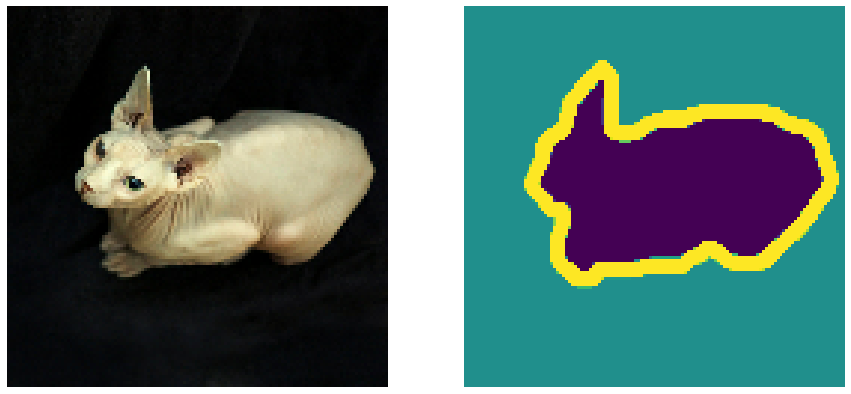

In [15]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',  
    'block_6_expand_relu',   
    'block_13_expand_relu',  
    'block_16_project',      
]
layers=[]
for i in layer_names:
    layers.append(base_model.get_layer(i).output)
encoder = tf.keras.Model(inputs=base_model.input, outputs=layers)
encoder.trainable = False

In [0]:
decode_layers = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

In [0]:
def make_model():
  last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2,
      padding='same', activation='softmax')

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs
  skips = encoder(x)
  x = skips[-1]
  skips = reversed(skips[:-1])
  for up, skip in zip(decode_layers, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
model = make_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

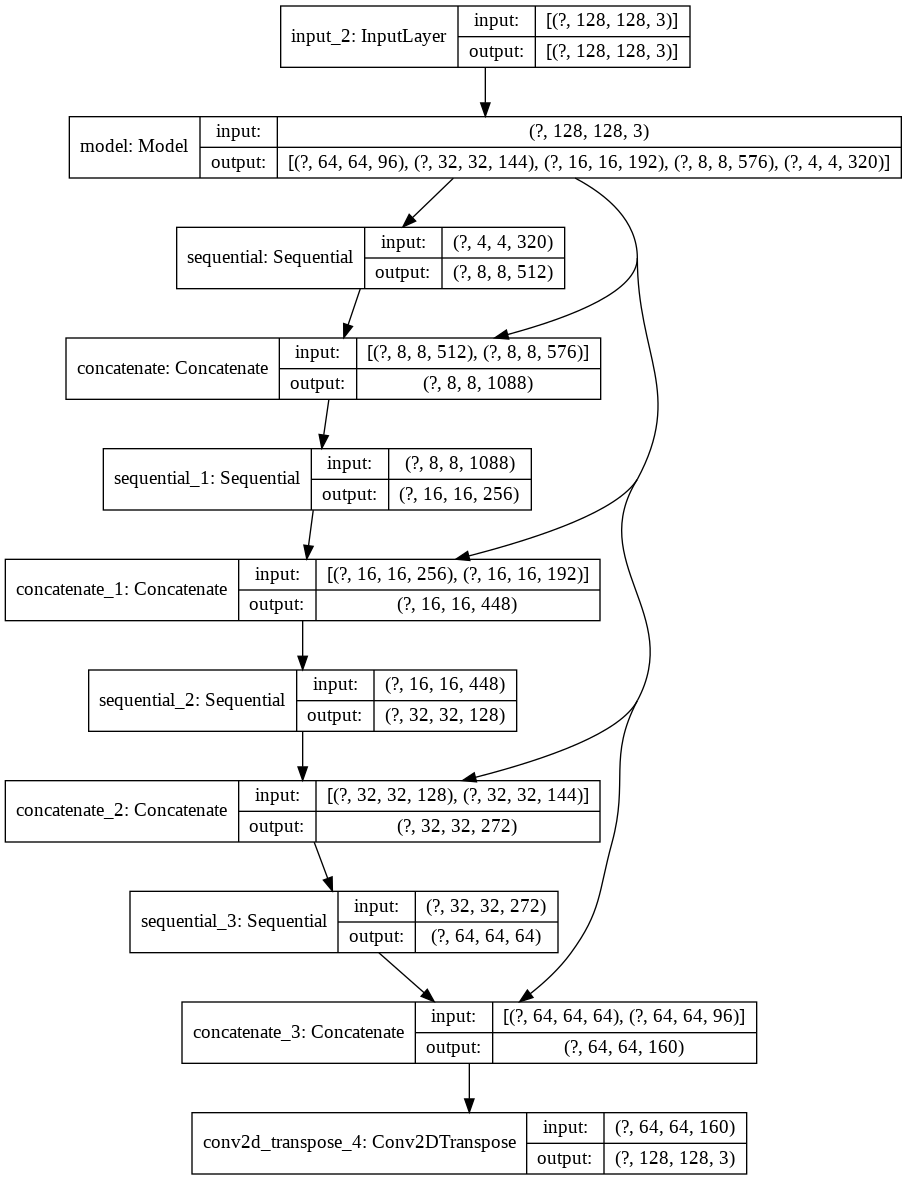

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_pred(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

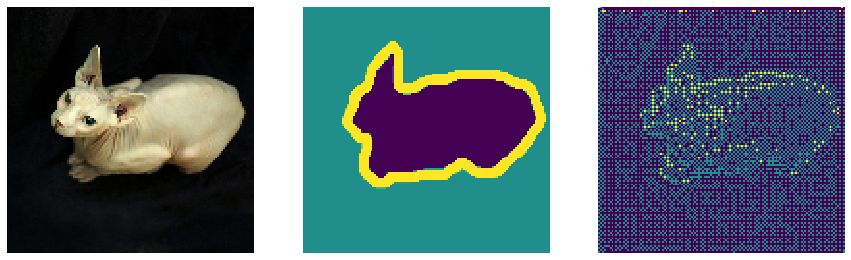

In [23]:
show_pred()

In [24]:
EPOCHS = 3
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Train for 57 steps, validate for 11 steps
Epoch 1/3
57/57 [==============================] - 374s 7s/step - loss: 0.4921 - accuracy: 0.7969 - val_loss: 0.5185 - val_accuracy: 0.8223
Epoch 2/3
57/57 [==============================] - 360s 6s/step - loss: 0.3004 - accuracy: 0.8775 - val_loss: 0.3337 - val_accuracy: 0.8658
Epoch 3/3
57/57 [==============================] - 353s 6s/step - loss: 0.2734 - accuracy: 0.8865 - val_loss: 0.3077 - val_accuracy: 0.8748


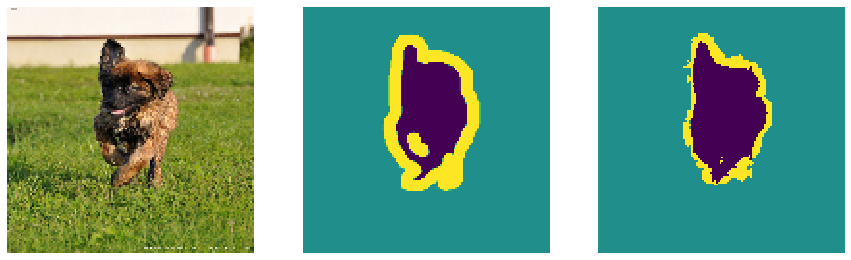

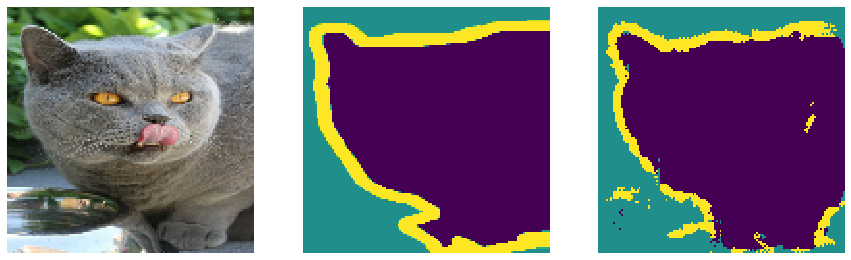

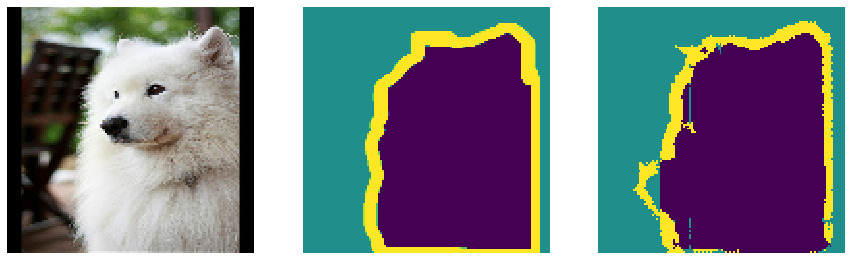

In [25]:
show_pred(test_dataset, 3)